In [1]:
from dataloader import ReyesDataset
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
train = ReyesDataset("../dataset/UCI/train.csv")
print(train.X.shape)
# calcula o hierariquico de X
Z = linkage(train.X[:,0,:].reshape(train.X.shape[0],train.X.shape[-1]), 'ward')

(7352, 9, 128)


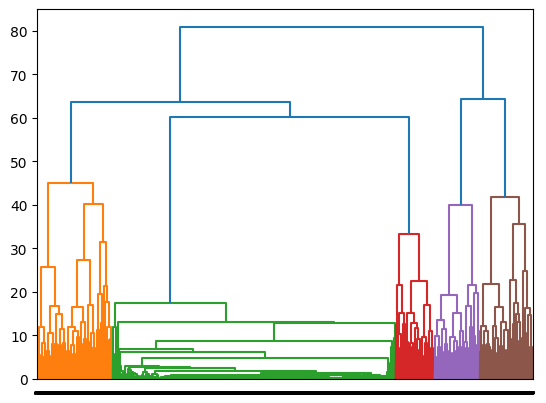

<Figure size 2500x1000 with 0 Axes>

In [3]:
dendrogram(Z, labels=train.Y)

plt.figure(figsize=(25, 10))
plt.show()

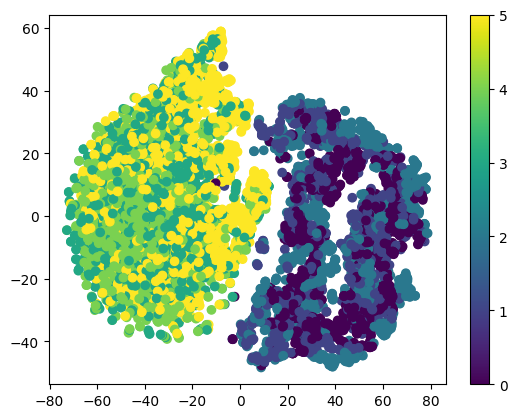

In [4]:
# mostra o tsne desses dados
from sklearn.manifold import TSNE
import numpy as np

X = train.X[:,0,:].reshape(train.X.shape[0],train.X.shape[-1])
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=train.Y)
plt.colorbar()
plt.show()

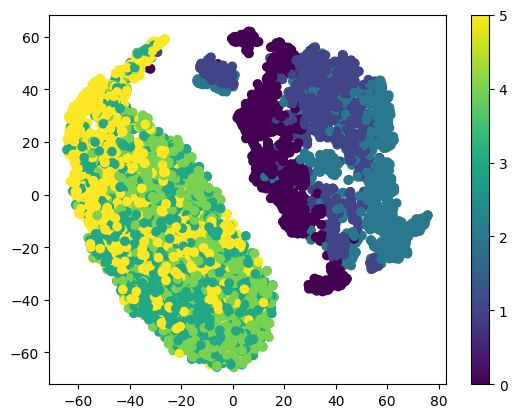

In [5]:
from scipy.fftpack import fft
import numpy as np

X_freq = np.abs(fft(X))
X_freq = X_freq[:,1:X.shape[1]//2]
X_embedded_freq = TSNE(n_components=2).fit_transform(X_freq)
plt.scatter(X_embedded_freq[:,0], X_embedded_freq[:,1], c=train.Y)
plt.colorbar()
plt.show()

In [6]:
Z_freq = linkage(X_freq, 'ward')

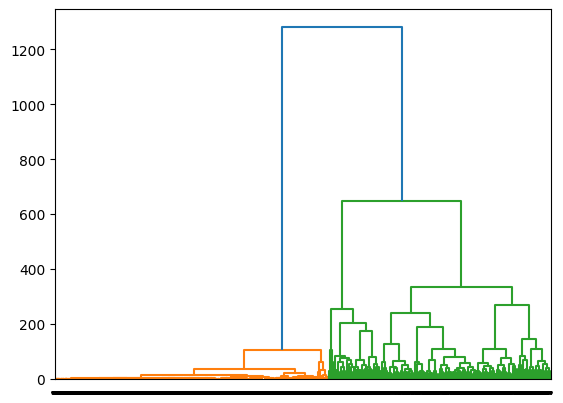

<Figure size 2500x1000 with 0 Axes>

In [7]:
dendrogram(Z_freq, labels=train.Y)

plt.figure(figsize=(25, 10))
plt.show()